In [ ]:
! pip install pillow

In [1]:
import pandas as pd
import numpy as np
import os 

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.preprocessing import image
from keras.models import Model, load_model
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', -1)

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("../02_Comprension de Datos/Imagenes.csv", sep = ';')
train_df.head()

,id,image
0,1060651400131,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00160651400131____1__516x640.jpg
1,1060651400180,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/06/00160651400180____1__516x640.jpg
2,1051056400107,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00151056400115____1__516x640.jpg
3,1019350401147,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00119350401147____3__516x640.jpg
4,1019353400229,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00119353400237____2__516x640.jpg


In [3]:
train_df.shape

(204812, 2)

In [4]:
train_df['id'].loc[40000:40003]

40000    001004560011738
40001    001004560011746
40002    001004560011753
40003    001004560011761
Name: id, dtype: object

In [54]:
def prepareImages(data, m):
    errors = []
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['id'].loc[40000:]:
        try:
            if count == m:
                break
            #load images into images of size 100x100x3
            img = image.load_img("../01_Comprension_de_Negocio/Images/"+fig+'.jpg', target_size=(100, 100, 3))
            x = image.img_to_array(img)
            #x = preprocess_input(x)

            X_train[count] = x
            if (count%5000 == 0):
                print("Processing image: ", count+1, ", ", fig)
            count += 1
            
        except:
            errors.append(fig)
            pass
    
    return X_train

In [55]:
%%time
X = prepareImages(train_df, 20000)
X_train = (X.astype(float))

Preparing images
Processing image:  1 ,  001004560011738
Processing image:  5001 ,  8435155579811
Processing image:  10001 ,  001015215568823
Processing image:  15001 ,  001028636100142
Wall time: 3min 38s


In [56]:
print (X_train.shape)

(20000, 52, 52, 3)


In [57]:
#print(np.mean(X_train))
#print(np.std(X_train))
print(np.max(X_train))

255.0


In [58]:
df = np.reshape(X_train, (X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))

In [59]:
images = pd.DataFrame(df)
images.head()

,0,1,2,3,4,5,6,7,8,9,...,8102,8103,8104,8105,8106,8107,8108,8109,8110,8111
0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,...,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0
1,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,...,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0
2,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,...,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0
3,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,...,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0
4,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,...,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0


In [60]:
images.shape

(20000, 8112)

In [61]:
#images.to_csv('Arrays_Images_20k.csv', sep = ';')

### Split training and validation set 

In [62]:
def normalize(data):
    #m = np.mean(data)
    #sd = np.std(data)
    #data = (data - m)/sd
    data = data / 255
    return data

X_train = normalize(X_train)

In [63]:
# Set the random seed
random_seed = 12

# Split the train and the validation set for the fitting
#X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state=random_seed)

## Autoencoder

In [98]:
input_img = Input(shape=(100,100,3))

#Encoder
x = Conv2D(50, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2,2), padding='same', name='ENCODER')(x)

#Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(50, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [99]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 100, 100, 50)      1400      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 50, 50, 32)        14432     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 25, 25, 16)        4624      
_________________________________________________________________
ENCODER (MaxPooling2D)       (None, 13, 13, 16)        0         
__________

##  Train

### Autoencoder

In [66]:
%%time
autoencoder.fit(X_train, X_train, epochs=2, batch_size=32, 
                callbacks=None, verbose = 1, shuffle=True )

Epoch 1/2
20000/20000 [==============================] - 469s 23ms/step - loss: 0.0256
Epoch 2/2
20000/20000 [==============================] - 462s 23ms/step - loss: 0.0151
Wall time: 15min 33s


In [67]:
#autoencoder.save('autoencoder_v2.h5')
#autoencoder = load_model('autoencoder_v2.h5')

### Encoder

In [68]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('ENCODER').output)

In [69]:
#encoder.save('encoder_v2.h5')

## Visualize original image and reconstructed image

In [70]:
X_train[100].shape

(52, 52, 3)

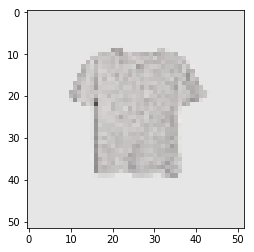

In [97]:
query = X_train[805]
plt.imshow(query)

### Encode the test images and the query image

In [81]:
X_test = X_train.copy()
X_test.shape

(20000, 52, 52, 3)

In [82]:
codes = encoder.predict(X_test)
codes.shape

(20000, 7, 7, 8)

In [83]:
query_code = encoder.predict(query.reshape(1,X_train.shape[1],X_train.shape[2],X_train.shape[3]))
query_code.shape

(1, 7, 7, 8)

### Find the closest images

In [85]:
codes = codes.reshape(-1, 13*13*16); 
print(codes.shape)
query_code = query_code.reshape(1, 13*13*16); 
print(query_code.shape)

(20000, 392)
(1, 392)


### Fit the KNN to the test set

In [86]:
n_neigh = 5

In [87]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

In [88]:
distances, indices = nbrs.kneighbors(np.array(query_code))

In [89]:
closest_images = X_test[indices]
closest_images = closest_images.reshape(-1,100,100,3); 
print(closest_images.shape)

(5, 52, 52, 3)


## Get the closest images


In [90]:
#m = np.mean(X_val)
#sd = np.std(X_val)

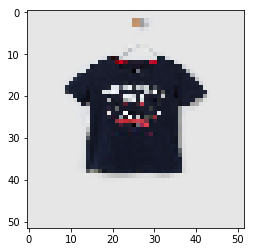

In [91]:
plt.imshow(query.reshape(100,100,3))

ValueError: cannot reshape array of size 8112 into shape (100,100,3)

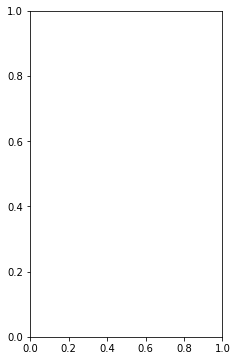

In [100]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    # display reconstruction
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(100, 100,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

---